## Using this notebook

This notebook loads **NLCD 2024 land cover data** for the Ramona study area, clips it to the Cedar Fire perimeter, and calculates land cover composition (with a focus on shrubland). Although this dataset is **only for 2024** and cannot be used for a full time-series analysis, it is still useful for:

- Getting a snapshot of what the Ramona/Cedar Fire area looks like in the most recent NLCD year.
- Confirming that shrubs are the dominant land cover type in this landscape (around ~60% of the area).
- Justifying the use of **RCMAP shrub cover time series (2000–2020)** as the main dataset for temporal analysis.

### Step 0: Load stored variables
- From previous notebooks call stored variables (paths, boundary, buffer, and fire perimeters).
### Step 1: Libraries and (if needed) define project paths and directories.
- Import required libraries.
### Step 2: Extract the NLCD 2024 GeoTIFF from the downloaded zip file.
- Use entire NLCD 2024 directory of land cover types. 
### Step 3: Open and inspect the NLCD raster
- Check the CRS (remember we are using California Albers!), shape, basic metadata.
### Step 4: Define NLCD class codes and helper functions for summarizing land cover.
- Defining class codes helps us interpret our chart later. 
### Step 5: Clip NLCD 2024 to the Cedar Fire perimeter
- Clip and compute class-level area percentages by class type. 
### Step 6: Visualize land cover composition
- Specifically for the Cedar Fire area in 2024 (e.g., shrubs, forest, developed).
### Step 7: Save figures
- Save the chart we create on land cover percentages within the Cedar Fire perimeter. 
### Step 8: Store key variables for use in later land cover and RCMAP notebooks.


### Step 0: Load stored variables

We start by using `%store -r` to restore variables saved in earlier notebooks, such as:

- `PROJECT_ROOT`, `DATA_DIR`, `BOUNDARY_DIR`, `LANDCOVER_DIR`
- The Ramona boundary and buffer
- Fire perimeters and target CRS

If these variables are already present in the current session, this step simply reloads them so we can reuse prior work without redefining everything.

In [1]:
%store -r

### Step 1: Import libraries and set up project paths

In this section, we:

- Import core libraries for working with vectors, rasters, and arrays (`geopandas`, `rioxarray`, `numpy`, `pandas`, `matplotlib`).
- Confirm or define the main project paths (e.g., `PROJECT_ROOT`, `DATA_DIR`, `LANDCOVER_DIR`).
- Ensure that any required directories exist for storing land cover inputs and outputs.

If you are running this notebook in sequence with the rest of the project, most of these paths and objects will already be available from earlier notebooks. In that case, this step serves mainly as a safety check and documentation of the expected environment.

In [ ]:
# Step 1: Libraries & Paths

import os
from pathlib import Path
import zipfile

import geopandas as gpd
import rioxarray as rxr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Some of the pathing has changed between notebooks.
# Reset directories:
PROJECT_ROOT = Path(r"C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery")
DATA_DIR = PROJECT_ROOT / "data"
BOUNDARY_DIR = DATA_DIR / "boundaries"

# New: landcover dir
LANDCOVER_DIR = DATA_DIR / "raw" / "landcover"

LANDCOVER_DIR


WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover')

### Step 2: Extract NLCD 2024 GeoTIFF from zip

The NLCD 2024 data is provided as a zipped archive. In this step we:

- Point to the NLCD 2024 zip file in `LANDCOVER_DIR`.
- Check whether the 2024 GeoTIFF has already been extracted.
- If not, unzip the file and write the `.tif` to disk for reuse.

This keeps the workflow reproducible and avoids manually unzipping files each time.

In [3]:
# Step 2: Extract NLCD 2024 GeoTIFFs from zip
zip_path = LANDCOVER_DIR / "Annual_NLCD_LndCov_2024_CU_C1V1.zip"
tif_name_2024 = "Annual_NLCD_LndCov_2024_CU_C1V1.tif"
tif_path_2024 = LANDCOVER_DIR / tif_name_2024

if not tif_path_2024.exists():
    print("Extracting NLCD 2024 from zip...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(LANDCOVER_DIR)
else:
    print("NLCD 2024 .tif already extracted.")

tif_path_2024


NLCD 2024 .tif already extracted.


WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover/Annual_NLCD_LndCov_2024_CU_C1V1.tif')

### Step 3: Open and inspect the NLCD 2024 raster

Here we load the NLCD 2024 GeoTIFF using `rioxarray` and:

- Confirm the coordinate reference system (CRS).
- Check the raster dimensions (rows, columns, bands).
- Make sure the data matches the expected spatial extent (CONUS, reprojectable to our study CRS).

This step ensures that the raster is correctly read and ready to be clipped to our Ramona/Cedar Fire study area.

In [4]:
# Step 3: Open and inspect the raster
# load the raster
nlcd_2024 = rxr.open_rasterio(
    tif_path_2024,
    chunks={"x": 2048, "y": 2048},   # small-ish tiles
    masked=True
).squeeze(drop=True)

print("CRS:", nlcd_2024.rio.crs)
print("Shape:", nlcd_2024.shape)

# You will notice in the output that this raster CRS is not California Albers. As we already have a variable with this projection
# (cedar_3310), we do not have to reproject this array.

CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Shape: (105000, 160000)


### Step 4: Define NLCD class codes and helper functions

To make the NLCD data interpretable, we:

- Create a dictionary (`NLCD_CLASSES`) that maps NLCD integer codes (e.g., 52) to readable class names (e.g., "Shrub/Scrub").
- Right now these all use numeric codes which is extremely hard to parse!
- Implement a helper function (e.g., `landcover_counts`) that:
  - Counts the number of pixels in each class.
  - Converts counts to area or percent of total area.
  - Returns a tidy DataFrame with class IDs, names, and percent cover.

This function will be reused whenever we want to summarize land cover composition within a given boundary (e.g., fire perimeter).

In [5]:
# Step 4: Define NLCD classes
# NLCD classes (Annual NLCD CONUS Collection 1.1)
NLCD_CLASSES = {
    11: "Open Water",
    12: "Perennial Ice/Snow",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    51: "Dwarf Scrub",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

def landcover_counts(da, nodata_values=(0,)):
    arr = da.values.astype("int32").ravel()
    mask = np.isin(arr, list(nodata_values), invert=True)
    arr = arr[mask]

    unique, counts = np.unique(arr, return_counts=True)
    total = counts.sum()

    df = pd.DataFrame({
        "class_code": unique,
        "pixel_count": counts,
        "percent": (counts / total) * 100
    })
    df["class_name"] = df["class_code"].map(NLCD_CLASSES)
    return df.sort_values("percent", ascending=False).reset_index(drop=True)


### Step 5.1: Define fire-year sets for later analysis

Even though this notebook only works with **NLCD 2024**, we define two sets of years for:

- `CEDAR_YEARS` – years before and after the 2003 Cedar Fire
- `WITCH_YEARS` – years before and after the 2007 Witch Fire

These year lists will be reused in later notebooks that work with **time-series data** (RCMAP shrubs and NDVI). Defining them here keeps the year logic consistent across the project.

In [6]:
# Step 5.1 set fire years
# Year sets for fires (these will be reused in later notebooks)
CEDAR_YEARS = {
    "pre_fire":  [2000, 2001, 2002],
    "fire_year": [2003],
    "post_fire": [2004, 2005, 2010, 2015, 2020],
}

WITCH_YEARS = {
    "pre_fire":  [2004, 2005, 2006],
    "fire_year": [2007],
    "post_fire": [2008, 2010, 2015, 2020],
}

CEDAR_YEARS, WITCH_YEARS

({'pre_fire': [2000, 2001, 2002],
  'fire_year': [2003],
  'post_fire': [2004, 2005, 2010, 2015, 2020]},
 {'pre_fire': [2004, 2005, 2006],
  'fire_year': [2007],
  'post_fire': [2008, 2010, 2015, 2020]})

### Step 5: Clip NLCD 2024 to the Cedar Fire area and summarize land cover

In this step, we:

1. Reproject the Cedar Fire perimeter (if needed) to match the NLCD 2024 CRS. We already have a variable for this (cedar_3310).
2. Use the fire perimeter to clip the NLCD raster so we only keep pixels inside the Cedar Fire footprint.
3. Convert the clipped raster into an `xarray.DataArray` (with `x` and `y` coordinates and a defined CRS).
4. Apply the `landcover_counts` helper function to produce a DataFrame (`df_cedar_2024`) with:
   - NLCD class ID
   - Class name (e.g., shrub, forest, developed)
   - Percent of the Cedar Fire area in each class

This gives us a snapshot of what the Cedar Fire landscape looks like in 2024 in terms of land cover composition.

In [7]:
# Step 5L Clip NLCD 2024 land cover to cedar fire area (cedar_3310)
# Example: if you already have cedar_3310 in memory:
import rasterio
from rasterio.windows import from_bounds
import xarray as xr

with rasterio.open(tif_path_2024) as src:
    # Make sure Cedar is in same CRS
    cedar_bounds = cedar_3310.to_crs(src.crs).total_bounds  # minx, miny, maxx, maxy

    window = from_bounds(*cedar_bounds, transform=src.transform)

    nlcd_cedar_arr = src.read(1, window=window)  # band 1, cropped window
    nlcd_cedar_transform = src.window_transform(window)
    nlcd_cedar_crs = src.crs

# Turn into an xarray DataArray with rioxarray metadata
rows, cols = nlcd_cedar_arr.shape
y = np.arange(rows)
x = np.arange(cols)

nlcd_2024_cedar = xr.DataArray(
    nlcd_cedar_arr,
    dims=("y", "x"),
    coords={"y": y, "x": x},
).rio.write_crs(nlcd_cedar_crs, inplace=True).rio.write_transform(nlcd_cedar_transform, inplace=True)

df_cedar_2024 = landcover_counts(nlcd_2024_cedar)
df_cedar_2024.head()

,class_code,pixel_count,percent,class_name
0,52,1547703,62.441369,Shrub/Scrub
1,22,218128,8.800274,"Developed, Low Intensity"
2,23,216846,8.748553,"Developed, Medium Intensity"
3,21,184886,7.459141,"Developed, Open Space"
4,71,123661,4.989046,Grassland/Herbaceous


### Step 6: Visualize land cover composition in the Cedar Fire area (2024)

Here we create a simple bar chart where:

- The x-axis shows NLCD class names (e.g., "Shrub/Scrub", "Evergreen Forest", "Developed").
- The y-axis shows the **percent of the Cedar Fire area** covered by each class in 2024.
- The figure title clearly labels the context: "Cedar Fire Area Landcover Composition (NLCD 2024)".

This visualization makes it easy to see that shrubland is the dominant land cover type in the Cedar Fire footprint in 2024 (around ~60% of the area), which supports our decision to focus on shrub dynamics using the RCMAP shrub dataset.

C:\Users\kayle\AppData\Local\Temp\ipykernel_13968\2360616132.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_cedar_2024["class_name"], rotation=90)


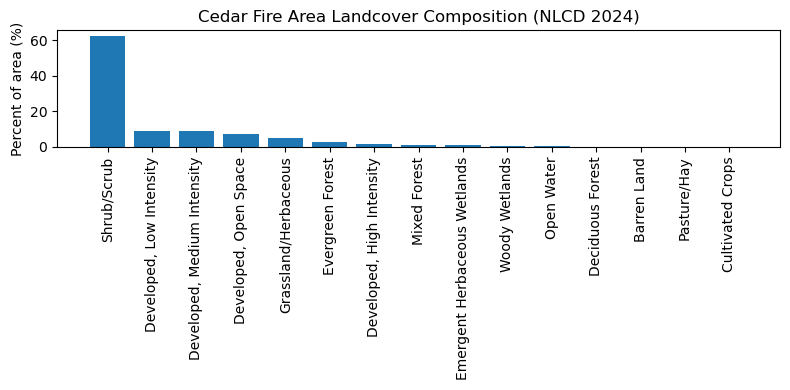

In [8]:
# Step 6: Visualize land composition
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df_cedar_2024["class_name"], df_cedar_2024["percent"])
ax.set_xticklabels(df_cedar_2024["class_name"], rotation=90)
ax.set_ylabel("Percent of area (%)")
ax.set_title("Cedar Fire Area Landcover Composition (NLCD 2024)")
plt.tight_layout()

In [9]:
# Step 7: Save the figure 
FIG_DIR = PROJECT_ROOT / "figures"
FIG_DIR.mkdir(exist_ok=True)

# Since we just named this fig, that is what we call below
# Unlike the previous notebook we did not use hvplot, but matplotlib

# Landcover percentage chart as STATIC figure
fig.savefig(FIG_DIR / "cedar_landcover_2024.png", dpi=300, bbox_inches="tight")

### Step 8: Store variables for later notebooks

Finally, we use `%store` to save key variables needed in subsequent land cover and vegetation analysis notebooks, such as:

- Directory paths (`PROJECT_ROOT`, `DATA_DIR`, `LANDCOVER_DIR`, etc.)
- Boundary and buffer geometries for Ramona
- Cedar/Witch Fire perimeters
- NLCD class mappings and year lists

Storing these objects here means we can reload them in later notebooks using `%store -r` without repeating setup steps. I will **remphasize** this again: You should **not** store large plot objects, but storing key configuration and geometry objects is very helpful for keeping the workflow modular.

In [10]:
# Store variables
%store PROJECT_ROOT DATA_DIR BOUNDARY_DIR LANDCOVER_DIR FIG_DIR cedar_2003 cedar_3310 witch_2007 witch_3310 ramona_3310 ramona_buffer ramona_buffer_union target_crs NLCD_CLASSES CEDAR_YEARS WITCH_YEARS

Stored 'PROJECT_ROOT' (WindowsPath)
Stored 'DATA_DIR' (WindowsPath)
Stored 'BOUNDARY_DIR' (WindowsPath)
Stored 'LANDCOVER_DIR' (WindowsPath)
Stored 'FIG_DIR' (WindowsPath)
Stored 'cedar_2003' (GeoDataFrame)
Stored 'cedar_3310' (GeoDataFrame)
Stored 'witch_2007' (GeoDataFrame)
Stored 'witch_3310' (GeoDataFrame)
Stored 'ramona_3310' (GeoDataFrame)
Stored 'ramona_buffer' (GeoSeries)
Stored 'ramona_buffer_union' (Polygon)
Stored 'target_crs' (str)
Stored 'NLCD_CLASSES' (dict)
Stored 'CEDAR_YEARS' (dict)
Stored 'WITCH_YEARS' (dict)


## What we learn from NLCD 2024

Although this notebook only uses **NLCD 2024**, it provides an important reality check:

- The Cedar Fire footprint in 2024 is still dominated by **shrubland**, making up close to ~60% of the area.
- Forest, grassland, and developed classes make up smaller proportions of the landscape.

This supports our decision to use **RCMAP shrub cover (2000–2020)** as the primary dataset for analyzing land cover change and fire recovery over time. NLCD 2024 acts as a single-year snapshot that confirms the shrub-dominated character of the Ramona/Cedar Fire landscape, while RCMAP provides the multi-year detail needed for trend analysis.
